# analyzing len experiment

In [68]:
import json
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from pathlib import Path

plt.style.use('seaborn-v0_8')
%matplotlib inline


In [69]:
# Base directory
base_dir = "/mnt/polished-lake/home/annabelma/other/results_fixed/continuous/continuous_soft_prompt_len_10epochs"

print(f"Results directory: {base_dir}")


Results directory: /mnt/polished-lake/home/annabelma/other/results_fixed/continuous/continuous_soft_prompt_len_10epochs


In [70]:
def load_all_histories(directory):
    """Load all history JSON files from a directory."""
    histories = {}
    
    # Find all history files
    history_files = glob.glob(os.path.join(directory, "history_*.json"))
    
    for filepath in history_files:
        # Parse filename: history_adversarial_{True/False}_lr_{lr}_promptlen_{promptlen}.json
        filename = os.path.basename(filepath)
        match = re.match(r"history_adversarial_(True|False)_lr_([0-9.e-]+)_promptlen_(\d+)\.json", filename)
        
        if match:
            adversarial_str = match.group(1)
            adversarial = adversarial_str == "True"
            lr_val = float(match.group(2))
            prompt_len = int(match.group(3))
            
            with open(filepath, 'r') as f:
                history = json.load(f)
            
            key = (adversarial, lr_val, prompt_len)
            histories[key] = history
            print(f"Loaded: adversarial={adversarial}, lr={lr_val}, prompt_len={prompt_len}")
    
    return histories


In [71]:
# Load histories
print("Loading all histories...")
all_histories = load_all_histories(base_dir)

# Separate by adversarial flag
non_adv_histories = {(adv, lr, pl): h for (adv, lr, pl), h in all_histories.items() if not adv}
adv_histories = {(adv, lr, pl): h for (adv, lr, pl), h in all_histories.items() if adv}

print(f"\nNon-adversarial: {len(non_adv_histories)} runs")
print(f"Adversarial: {len(adv_histories)} runs")


Loading all histories...
Loaded: adversarial=False, lr=0.0001, prompt_len=1
Loaded: adversarial=False, lr=0.0001, prompt_len=10
Loaded: adversarial=False, lr=0.0001, prompt_len=100
Loaded: adversarial=False, lr=0.0001, prompt_len=20
Loaded: adversarial=False, lr=0.0001, prompt_len=5
Loaded: adversarial=False, lr=0.0001, prompt_len=50
Loaded: adversarial=True, lr=0.001, prompt_len=1
Loaded: adversarial=True, lr=0.001, prompt_len=10
Loaded: adversarial=True, lr=0.001, prompt_len=100
Loaded: adversarial=True, lr=0.001, prompt_len=20
Loaded: adversarial=True, lr=0.001, prompt_len=5
Loaded: adversarial=True, lr=0.001, prompt_len=50

Non-adversarial: 6 runs
Adversarial: 6 runs


In [75]:
def plot_learning_curves(histories, title_prefix="", max_epochs=None):
    """Plot learning curves for continuous soft prompts, grouped by learning rate.
    
    Args:
        histories: Dictionary of histories
        title_prefix: Prefix for plot titles
        max_epochs: Maximum number of epochs to plot (None = plot all)
    """
    
    if not histories:
        print("No histories to plot")
        return []
    
    # Group by learning rate (since we're varying prompt length)
    lr_values = sorted(set(k[1] for k in histories.keys()))
    prompt_lengths = sorted(set(k[2] for k in histories.keys()))
    
    figs = []
    
    for lr in lr_values:
        # Filter histories for this learning rate
        lr_histories = {(adv, l, pl): h for (adv, l, pl), h in histories.items() if l == lr}
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f"{title_prefix}Continuous Soft Prompt Learning Curves - LR={lr:.0e}", fontsize=16, fontweight='bold')
        
        # Plot 1: Training Task Loss
        ax1 = axes[0, 0]
        for (adv, l, pl), history in sorted(lr_histories.items()):
            if 'train_task' in history:
                data = history['train_task'][:max_epochs] if max_epochs else history['train_task']
                epochs = range(1, len(data) + 1)
                ax1.plot(epochs, data, marker='o', label=f"prompt_len={pl}", linewidth=2, markersize=6)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Training Task Loss')
        ax1.set_title(f'Continuous Soft Prompt: Training Task Loss (LR={lr:.0e})')
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Validation Loss
        ax2 = axes[0, 1]
        for (adv, l, pl), history in sorted(lr_histories.items()):
            data = history['val_loss'][:max_epochs] if max_epochs else history['val_loss']
            epochs = range(1, len(data) + 1)
            ax2.plot(epochs, data, marker='o', label=f"prompt_len={pl}", linewidth=2, markersize=6)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Validation Loss')
        ax2.set_title(f'Continuous Soft Prompt: Validation Loss (LR={lr:.0e})')
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Validation Accuracy
        ax3 = axes[1, 0]
        for (adv, l, pl), history in sorted(lr_histories.items()):
            data = history['val_acc'][:max_epochs] if max_epochs else history['val_acc']
            epochs = range(1, len(data) + 1)
            ax3.plot(epochs, data, marker='o', label=f"prompt_len={pl}", linewidth=2, markersize=6)
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Validation Accuracy')
        ax3.set_title(f'Continuous Soft Prompt: Validation Accuracy (LR={lr:.0e})')
        ax3.legend(fontsize=10)
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Prompt Norm
        ax4 = axes[1, 1]
        for (adv, l, pl), history in sorted(lr_histories.items()):
            if 'prompt_norm' in history:
                data = history['prompt_norm'][:max_epochs] if max_epochs else history['prompt_norm']
                epochs = range(1, len(data) + 1)
                ax4.plot(epochs, data, marker='o', label=f"prompt_len={pl}", linewidth=2, markersize=6)
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Soft Prompt Norm (L2)')
        ax4.set_title(f'Continuous Soft Prompt: Prompt Norm (LR={lr:.0e})')
        ax4.legend(fontsize=10)
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        figs.append(fig)
    
    return figs


Plotting non-adversarial continuous soft prompt learning curves...


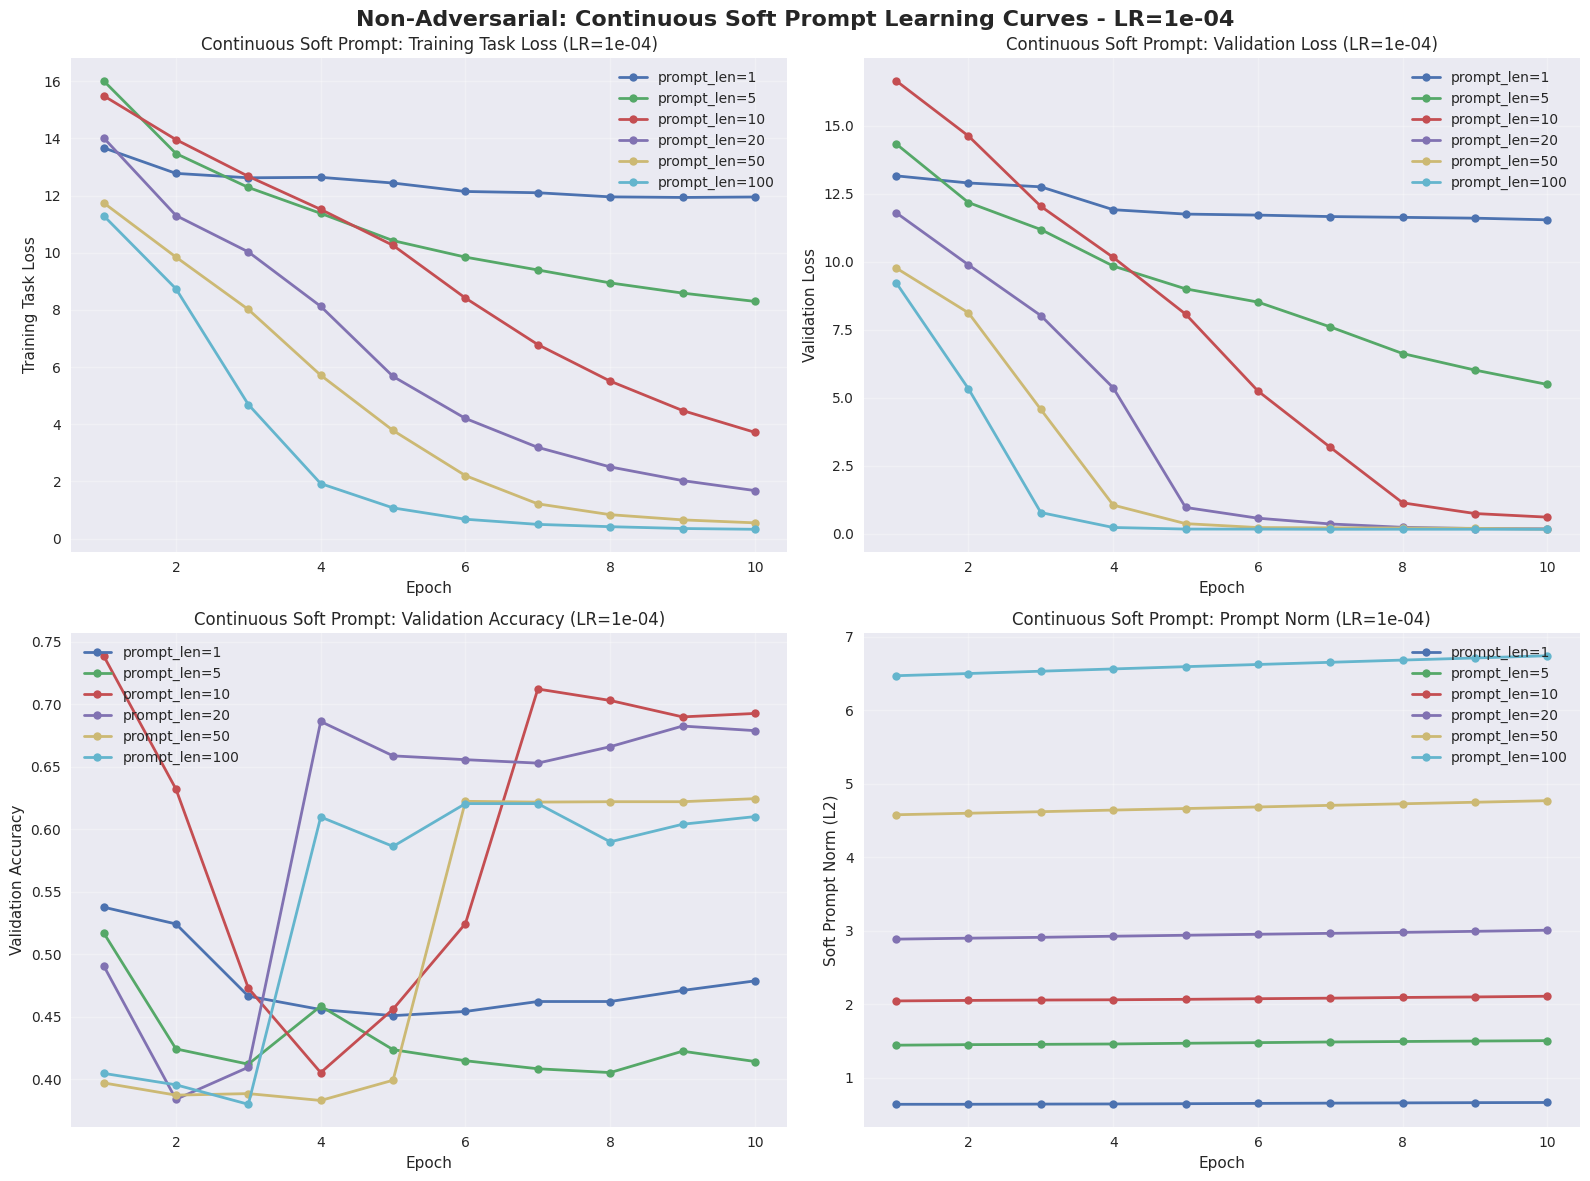

In [76]:
# Plot non-adversarial learning curves
print("Plotting non-adversarial continuous soft prompt learning curves...")
if non_adv_histories:
    figs_non_adv = plot_learning_curves(non_adv_histories, title_prefix="Non-Adversarial: ")
    for fig in figs_non_adv:
        plt.show()
else:
    print("No non-adversarial continuous soft prompt histories found")


Plotting adversarial continuous soft prompt learning curves (first 5 epochs)...


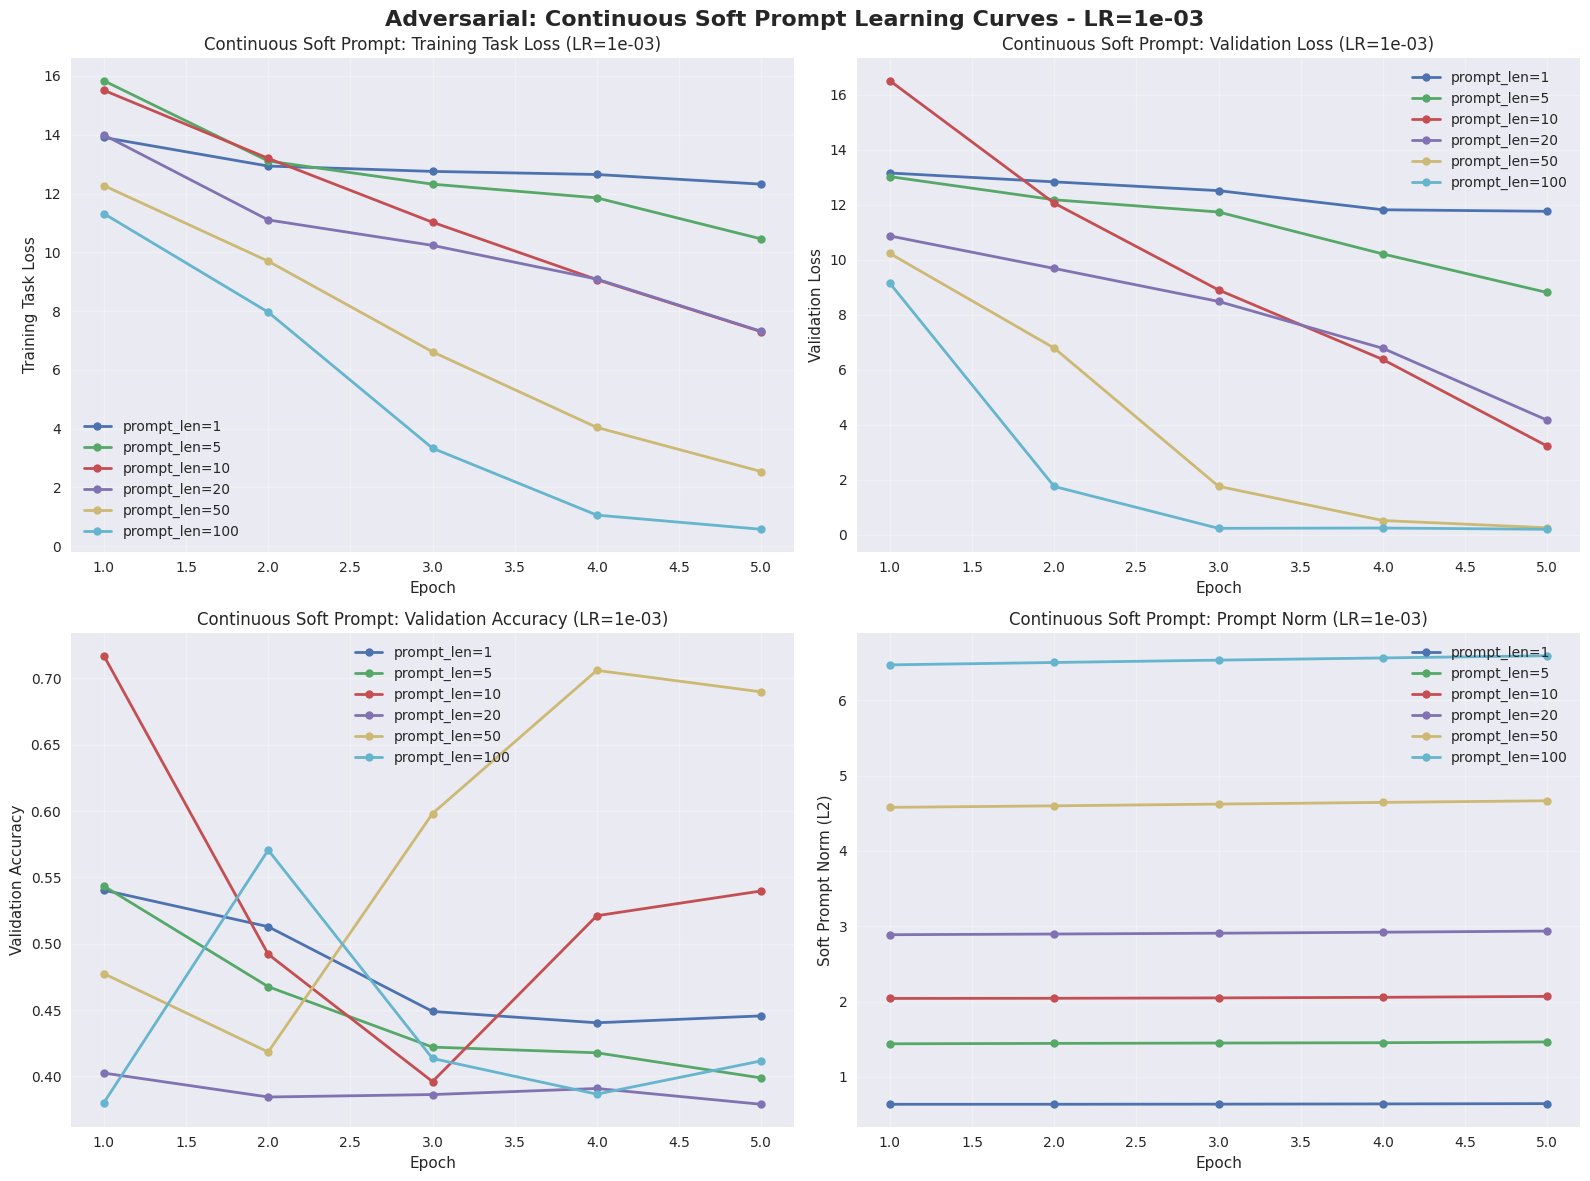

In [77]:
# Plot adversarial learning curves (only first 5 epochs)
print("Plotting adversarial continuous soft prompt learning curves (first 5 epochs)...")
if adv_histories:
    figs_adv = plot_learning_curves(adv_histories, title_prefix="Adversarial: ", max_epochs=5)
    for fig in figs_adv:
        plt.show()
else:
    print("No adversarial continuous soft prompt histories found")


In [59]:
# Summary table
print("\n" + "=" * 80)
print("CONTINUOUS SOFT PROMPT: SUMMARY TABLE")
print("=" * 80)

summary_data = []

for (adv, lr, pl), history in sorted(all_histories.items()):
    best_val_acc = max(history['val_acc'])
    final_val_acc = history['val_acc'][-1]
    best_true_acc = max(history['val_acc_true'])
    best_false_acc = max(history['val_acc_false'])
    final_prompt_norm = history['prompt_norm'][-1] if 'prompt_norm' in history else None
    
    summary_data.append({
        'Adversarial': 'Yes' if adv else 'No',
        'Learning Rate': f"{lr:.0e}",
        'Prompt Length': pl,
        'Best Val Acc': best_val_acc,
        'Final Val Acc': final_val_acc,
        'Best True Acc': best_true_acc,
        'Best False Acc': best_false_acc,
        'Final Prompt Norm': final_prompt_norm
    })

df = pd.DataFrame(summary_data)
print(df.to_string(index=False))



CONTINUOUS SOFT PROMPT: SUMMARY TABLE
Adversarial Learning Rate  Prompt Length  Best Val Acc  Final Val Acc  Best True Acc  Best False Acc  Final Prompt Norm
         No         1e-04              1      0.537615       0.478593       0.286768        0.966855           0.661528
         No         1e-04              5      0.517125       0.414067       0.242499        0.991108           1.503387
         No         1e-04             10      0.738838       0.692661       0.954255        0.992724           2.107683
         No         1e-04             20      0.686239       0.678899       0.995573        0.998383           3.006603
         No         1e-04             50      0.624465       0.624465       1.000000        0.990299           4.769903
         No         1e-04            100      0.620489       0.610092       0.979341        0.997575           6.742482
        Yes         1e-03              1      0.540367       0.484098       0.291687        0.965238           0.658952
 

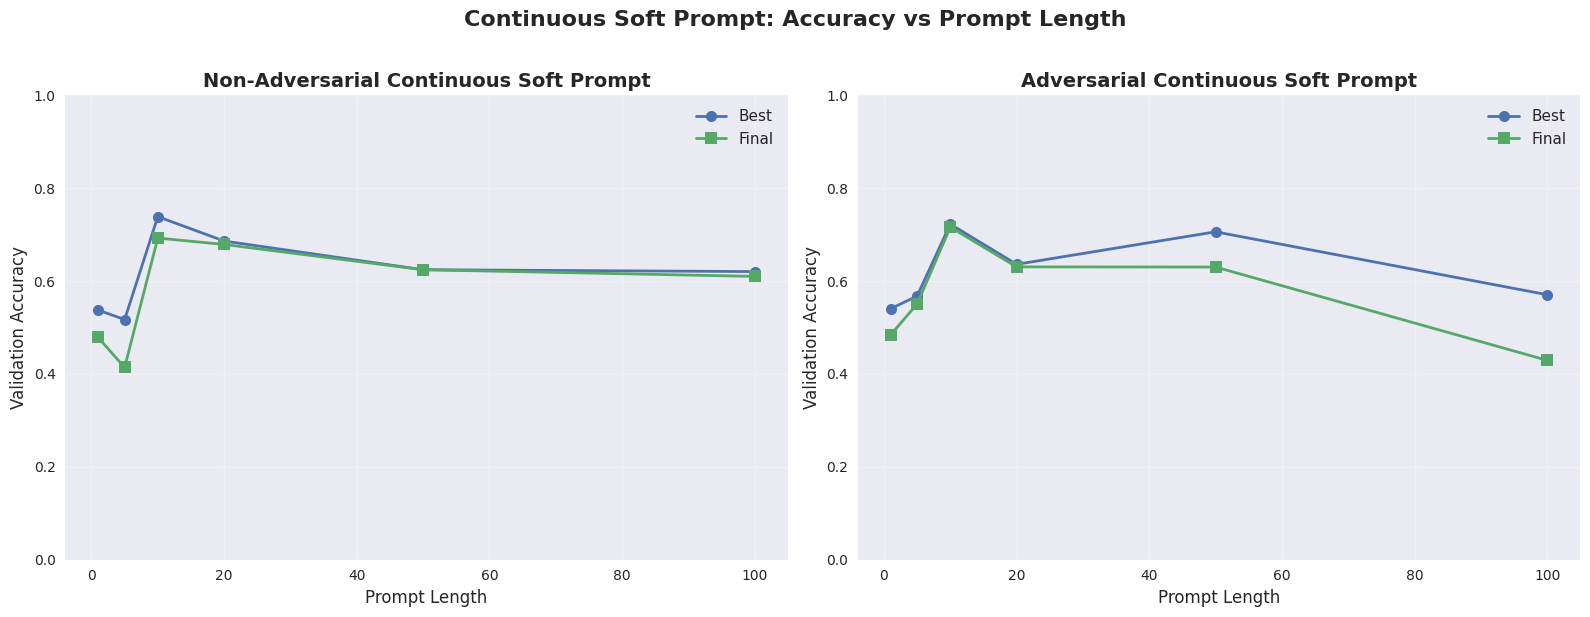

In [61]:
# Comparison plot: Best accuracy vs Prompt Length
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Continuous Soft Prompt: Accuracy vs Prompt Length', fontsize=16, fontweight='bold', y=1.02)

# Non-adversarial
if non_adv_histories:
    ax1 = axes[0]
    prompt_lengths = sorted(set(k[2] for k in non_adv_histories.keys()))
    best_accs = []
    final_accs = []
    for pl in prompt_lengths:
        # Find history for this prompt length (use first LR found)
        for (adv, lr, p), history in non_adv_histories.items():
            if p == pl:
                best_accs.append(max(history['val_acc']))
                final_accs.append(history['val_acc'][-1])
                break
    
    ax1.plot(prompt_lengths, best_accs, marker='o', label='Best', linewidth=2, markersize=8)
    ax1.plot(prompt_lengths, final_accs, marker='s', label='Final', linewidth=2, markersize=8)
    ax1.set_xlabel('Prompt Length', fontsize=12)
    ax1.set_ylabel('Validation Accuracy', fontsize=12)
    ax1.set_title('Non-Adversarial Continuous Soft Prompt', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])

# Adversarial
if adv_histories:
    ax2 = axes[1]
    prompt_lengths = sorted(set(k[2] for k in adv_histories.keys()))
    best_accs = []
    final_accs = []
    for pl in prompt_lengths:
        # Find history for this prompt length (use first LR found)
        for (adv, lr, p), history in adv_histories.items():
            if p == pl:
                best_accs.append(max(history['val_acc']))
                final_accs.append(history['val_acc'][-1])
                break
    
    ax2.plot(prompt_lengths, best_accs, marker='o', label='Best', linewidth=2, markersize=8)
    ax2.plot(prompt_lengths, final_accs, marker='s', label='Final', linewidth=2, markersize=8)
    ax2.set_xlabel('Prompt Length', fontsize=12)
    ax2.set_ylabel('Validation Accuracy', fontsize=12)
    ax2.set_title('Adversarial Continuous Soft Prompt', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 1])

plt.tight_layout()
plt.show()


In [62]:
# Create table: Prompt Length vs Epoch (Validation Accuracy)
def create_epoch_accuracy_table(histories, metric='val_acc'):
    """Create a table with prompt lengths as rows and epochs as columns.
    
    Args:
        histories: Dictionary of histories
        metric: Which metric to use ('val_acc', 'val_acc_true', 'val_acc_false')
    """
    
    if not histories:
        return None
    
    # Get all prompt lengths and find max epochs
    prompt_lengths = sorted(set(k[2] for k in histories.keys()))
    max_epochs = 0
    
    # Find maximum number of epochs across all histories
    for (adv, lr, pl), history in histories.items():
        if metric in history:
            max_epochs = max(max_epochs, len(history[metric]))
    
    # Create table data
    table_data = []
    for pl in prompt_lengths:
        # Find a history for this prompt length (use first one found)
        row_data = {'Prompt Length': pl}
        for (adv, lr, p), history in histories.items():
            if p == pl and metric in history:
                # Fill in accuracies for each epoch
                for epoch_idx, acc in enumerate(history[metric], start=1):
                    row_data[f'Epoch {epoch_idx}'] = acc
                break
        table_data.append(row_data)
    
    # Create DataFrame
    df = pd.DataFrame(table_data)
    
    # Reorder columns: Prompt Length first, then epochs
    cols = ['Prompt Length'] + [f'Epoch {i}' for i in range(1, max_epochs + 1)]
    df = df.reindex(columns=[c for c in cols if c in df.columns])
    
    return df

# Create tables for non-adversarial
print("\n" + "=" * 80)
print("NON-ADVERSARIAL: Overall Validation Accuracy by Prompt Length and Epoch")
print("=" * 80)
if non_adv_histories:
    df_non_adv_total = create_epoch_accuracy_table(non_adv_histories, metric='val_acc')
    if df_non_adv_total is not None:
        print(df_non_adv_total.to_string(index=False))
else:
    print("No non-adversarial histories found")

print("\n" + "=" * 80)
print("NON-ADVERSARIAL: True (Yes) Accuracy by Prompt Length and Epoch")
print("=" * 80)
if non_adv_histories:
    df_non_adv_true = create_epoch_accuracy_table(non_adv_histories, metric='val_acc_true')
    if df_non_adv_true is not None:
        print(df_non_adv_true.to_string(index=False))
else:
    print("No non-adversarial histories found")

print("\n" + "=" * 80)
print("NON-ADVERSARIAL: False (No) Accuracy by Prompt Length and Epoch")
print("=" * 80)
if non_adv_histories:
    df_non_adv_false = create_epoch_accuracy_table(non_adv_histories, metric='val_acc_false')
    if df_non_adv_false is not None:
        print(df_non_adv_false.to_string(index=False))
else:
    print("No non-adversarial histories found")

# Create tables for adversarial
print("\n" + "=" * 80)
print("ADVERSARIAL: Overall Validation Accuracy by Prompt Length and Epoch")
print("=" * 80)
if adv_histories:
    df_adv_total = create_epoch_accuracy_table(adv_histories, metric='val_acc')
    if df_adv_total is not None:
        print(df_adv_total.to_string(index=False))
else:
    print("No adversarial histories found")

print("\n" + "=" * 80)
print("ADVERSARIAL: True (Yes) Accuracy by Prompt Length and Epoch")
print("=" * 80)
if adv_histories:
    df_adv_true = create_epoch_accuracy_table(adv_histories, metric='val_acc_true')
    if df_adv_true is not None:
        print(df_adv_true.to_string(index=False))
else:
    print("No adversarial histories found")

print("\n" + "=" * 80)
print("ADVERSARIAL: False (No) Accuracy by Prompt Length and Epoch")
print("=" * 80)
if adv_histories:
    df_adv_false = create_epoch_accuracy_table(adv_histories, metric='val_acc_false')
    if df_adv_false is not None:
        print(df_adv_false.to_string(index=False))
else:
    print("No adversarial histories found")



NON-ADVERSARIAL: Overall Validation Accuracy by Prompt Length and Epoch
 Prompt Length  Epoch 1  Epoch 2  Epoch 3  Epoch 4  Epoch 5  Epoch 6  Epoch 7  Epoch 8  Epoch 9  Epoch 10
             1 0.537615 0.524159 0.466361 0.455657 0.450765 0.454128 0.462080 0.462080 0.470948  0.478593
             5 0.517125 0.424159 0.411927 0.458410 0.423547 0.414679 0.408257 0.405199 0.422324  0.414067
            10 0.738838 0.632110 0.472783 0.405199 0.455963 0.524465 0.712232 0.703058 0.689908  0.692661
            20 0.490826 0.383792 0.409480 0.686239 0.658716 0.655657 0.652905 0.666055 0.682569  0.678899
            50 0.396942 0.387156 0.388379 0.382875 0.399083 0.622324 0.621713 0.622018 0.622018  0.624465
           100 0.404587 0.395413 0.379817 0.609786 0.586239 0.620489 0.620489 0.589908 0.603976  0.610092

NON-ADVERSARIAL: True (Yes) Accuracy by Prompt Length and Epoch
 Prompt Length  Epoch 1  Epoch 2  Epoch 3  Epoch 4  Epoch 5  Epoch 6  Epoch 7  Epoch 8  Epoch 9  Epoch 10
             1

In [67]:
# Unembed continuous soft prompts and calculate perplexity
import torch
import torch.nn as nn
import math
from transformers import (
    T5ForConditionalGeneration,
    T5TokenizerFast,
    GPT2LMHeadModel,
    GPT2TokenizerFast,
)

# Load GPT-2 for perplexity calculation
print("Loading GPT-2 for perplexity calculation...")
device = "cuda" if torch.cuda.is_available() else "cpu"
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
gpt2_model.eval()
for p in gpt2_model.parameters():
    p.requires_grad = False

# Load T5 tokenizer
t5_tokenizer = T5TokenizerFast.from_pretrained("t5-large")

def compute_prompt_ppl_loss_from_text(
    gpt2_model: GPT2LMHeadModel,
    gpt2_tokenizer: GPT2TokenizerFast,
    prompt_text: str,
    device: str,
) -> torch.Tensor:
    """Take decoded prompt text, feed to GPT-2, compute LM loss."""
    if not prompt_text or not prompt_text.strip():
        return torch.tensor(0.0, device=device)

    enc = gpt2_tokenizer(prompt_text, return_tensors="pt", truncation=True)
    input_ids = enc["input_ids"].to(device)

    if input_ids.numel() == 0:
        return torch.tensor(0.0, device=device)

    labels = input_ids.clone()
    with torch.no_grad():
        outputs = gpt2_model(input_ids=input_ids, labels=labels)
    return outputs.loss

def unembed_continuous_prompt(soft_prompt_embeds, t5_model, device="cuda"):
    """
    Convert continuous soft prompt embeddings to discrete token IDs.
    Uses nearest neighbor search in embedding space.
    
    Args:
        soft_prompt_embeds: (prompt_length, d_model) tensor
        t5_model: T5 model to get embedding matrix from
        device: device to use
    
    Returns:
        token_ids: (prompt_length,) tensor of token IDs
    """
    # Get embedding matrix: (vocab_size, d_model)
    embed_matrix = t5_model.encoder.embed_tokens.weight  # (V, d_model)
    
    # Compute cosine similarity or L2 distance for each prompt position
    # soft_prompt_embeds: (L, d_model)
    # embed_matrix: (V, d_model)
    
    # Normalize for cosine similarity
    soft_prompt_norm = torch.nn.functional.normalize(soft_prompt_embeds, p=2, dim=1)  # (L, d_model)
    embed_matrix_norm = torch.nn.functional.normalize(embed_matrix, p=2, dim=1)  # (V, d_model)
    
    # Compute cosine similarity: (L, V)
    similarities = torch.matmul(soft_prompt_norm, embed_matrix_norm.t())
    
    # Get argmax for each position
    token_ids = similarities.argmax(dim=1)  # (L,)
    
    return token_ids

def decode_continuous_prompt(model_path, prompt_length, t5_tokenizer, t5_model, device="cuda"):
    """
    Load a continuous soft prompt model and decode it to text.
    
    Args:
        model_path: Path to saved model state dict
        prompt_length: Length of the prompt
        t5_tokenizer: T5 tokenizer
        t5_model: T5 model (to get embedding matrix)
        device: device to use
    
    Returns:
        prompt_text: Decoded text of the prompt
        token_ids: Token IDs
    """
    # Load model state dict
    state_dict = torch.load(model_path, map_location=device)
    
    # Extract soft_prompt parameter
    # The state dict should have 'soft_prompt' key
    if 'soft_prompt' in state_dict:
        soft_prompt_embeds = state_dict['soft_prompt'].to(device)
    else:
        # Try alternative key names (in case of nested structure)
        found = False
        for key in state_dict.keys():
            if 'soft_prompt' in key.lower():
                soft_prompt_embeds = state_dict[key].to(device)
                found = True
                break
        if not found:
            # Print available keys for debugging
            print(f"Available keys in {model_path}: {list(state_dict.keys())[:10]}")
            raise ValueError(f"Could not find soft_prompt in {model_path}. Available keys: {list(state_dict.keys())}")
    
    # Verify shape
    if soft_prompt_embeds.shape[0] != prompt_length:
        print(f"Warning: Expected prompt length {prompt_length}, got {soft_prompt_embeds.shape[0]}")
    
    # Unembed to get token IDs
    token_ids = unembed_continuous_prompt(soft_prompt_embeds, t5_model, device)
    
    # Decode to text
    prompt_text = t5_tokenizer.decode(
        token_ids.tolist(),
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True,
    ).strip()
    
    return prompt_text, token_ids

# Load T5 model for unembedding
print("Loading T5 model for unembedding...")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-large").to(device)
t5_model.eval()
for p in t5_model.parameters():
    p.requires_grad = False

print("Ready to unembed prompts and calculate perplexity.")


Loading GPT-2 for perplexity calculation...
Loading T5 model for unembedding...
Ready to unembed prompts and calculate perplexity.


In [65]:
# Unembed all prompts and calculate perplexity
print("\n" + "=" * 80)
print("UNEMBEDDING CONTINUOUS PROMPTS AND CALCULATING PERPLEXITY")
print("=" * 80)

prompt_results = []

for (adv, lr, pl), history in sorted(all_histories.items()):
    # Find corresponding model file
    model_filename = f"model_adversarial_{adv}_lr_{lr}_promptlen_{pl}.pt"
    model_path = os.path.join(base_dir, model_filename)
    
    if not os.path.exists(model_path):
        print(f"Warning: Model file not found: {model_path}")
        continue
    
    try:
        # Decode the prompt
        prompt_text, token_ids = decode_continuous_prompt(
            model_path, pl, t5_tokenizer, t5_model, device=device
        )
        
        # Calculate perplexity
        if prompt_text:
            ppl_loss = compute_prompt_ppl_loss_from_text(
                gpt2_model, gpt2_tokenizer, prompt_text, device=device
            )
            ppl = math.exp(ppl_loss.item()) if not (torch.isnan(ppl_loss) or torch.isinf(ppl_loss)) else float('nan')
        else:
            ppl_loss = torch.tensor(0.0, device=device)
            ppl = 0.0
        
        prompt_results.append({
            'adversarial': adv,
            'lr': lr,
            'prompt_length': pl,
            'prompt_text': prompt_text,
            'token_ids': token_ids.tolist(),
            'perplexity': ppl,
            'ppl_loss': ppl_loss.item() if isinstance(ppl_loss, torch.Tensor) else ppl_loss
        })
        
        print(f"\nAdversarial={adv}, LR={lr:.0e}, Prompt Length={pl}:")
        print(f"  Prompt: {prompt_text[:100]}..." if len(prompt_text) > 100 else f"  Prompt: {prompt_text}")
        print(f"  Perplexity: {ppl:.2f}")
        
    except Exception as e:
        print(f"Error processing {model_path}: {e}")
        import traceback
        traceback.print_exc()

print(f"\nProcessed {len(prompt_results)} prompts.")



UNEMBEDDING CONTINUOUS PROMPTS AND CALCULATING PERPLEXITY

Adversarial=False, LR=1e-04, Prompt Length=1:
  Prompt: 
  Perplexity: 0.00


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.



Adversarial=False, LR=1e-04, Prompt Length=5:
  Prompt: Uber Persoan Zusatzsavvy
  Perplexity: 20998.27

Adversarial=False, LR=1e-04, Prompt Length=10:
  Prompt: Kol model sheep wellness Ros Daniel Klein carte?
  Perplexity: 51241.06

Adversarial=False, LR=1e-04, Prompt Length=20:
  Prompt: miercuri model Nar Su heute Bh MonteArchitect nicely Sam dishwasher startup my Cal boxes windshieldc...
  Perplexity: 42145.20

Adversarial=False, LR=1e-04, Prompt Length=50:
  Prompt: FM Kendall sprinkle notice Ministercosm Toast stainless nicelybel necesar ERP dryingappropri telefon...
  Perplexity: 21331.81

Adversarial=False, LR=1e-04, Prompt Length=100:
  Prompt: proposition wipe animalsavvy Industry Übersicht Monte summarize sarcinibeln Sneak Joyianu pragutuft ...
  Perplexity: 19940.55

Adversarial=True, LR=1e-03, Prompt Length=1:
  Prompt: 
  Perplexity: 0.00

Adversarial=True, LR=1e-03, Prompt Length=5:
  Prompt: Klein emergency Kleingeschaltet
  Perplexity: 18587.24

Adversarial=True, LR=


PROMPT PERPLEXITY BY PROMPT LENGTH
Adversarial Learning Rate  Prompt Length   Perplexity                                           Prompt Text
         No         1e-04              1     0.000000                                                      
         No         1e-04              5 20998.266539                              Uber Persoan Zusatzsavvy
         No         1e-04             10 51241.060647      Kol model sheep wellness Ros Daniel Klein carte?
         No         1e-04             20 42145.204731 miercuri model Nar Su heute Bh MonteArchitect nice...
         No         1e-04             50 21331.809376 FM Kendall sprinkle notice Ministercosm Toast stai...
         No         1e-04            100 19940.553232 proposition wipe animalsavvy Industry Übersicht Mo...
        Yes         1e-03              1     0.000000                                                      
        Yes         1e-03              5 18587.242047                       Klein emergency Kleinges

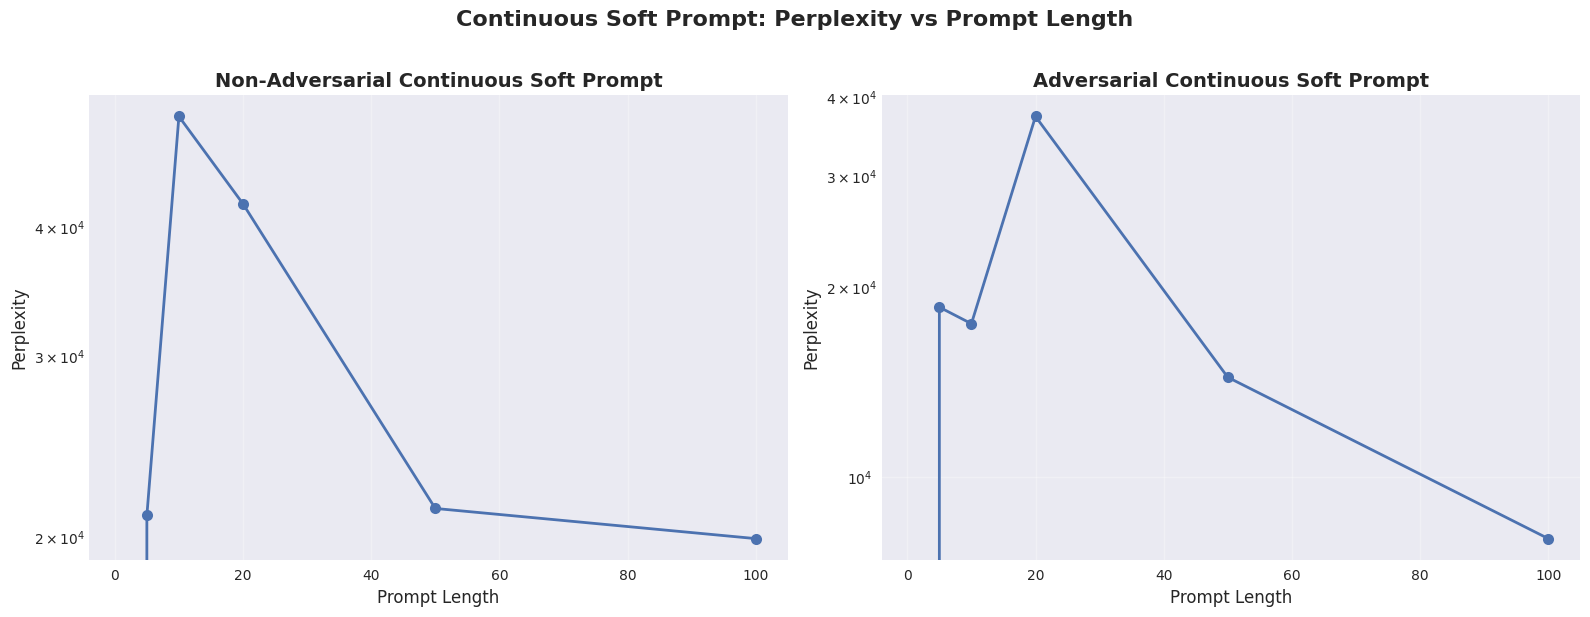

In [66]:
# Create table of prompt perplexity by prompt length
print("\n" + "=" * 80)
print("PROMPT PERPLEXITY BY PROMPT LENGTH")
print("=" * 80)

# Create DataFrame
ppl_data = []
for result in prompt_results:
    ppl_data.append({
        'Adversarial': 'Yes' if result['adversarial'] else 'No',
        'Learning Rate': f"{result['lr']:.0e}",
        'Prompt Length': result['prompt_length'],
        'Perplexity': result['perplexity'],
        'Prompt Text': result['prompt_text'][:50] + '...' if len(result['prompt_text']) > 50 else result['prompt_text']
    })

df_ppl = pd.DataFrame(ppl_data)
print(df_ppl.to_string(index=False))

# Plot perplexity vs prompt length
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Continuous Soft Prompt: Perplexity vs Prompt Length', fontsize=16, fontweight='bold', y=1.02)

# Non-adversarial
non_adv_ppl = [r for r in prompt_results if not r['adversarial']]
if non_adv_ppl:
    ax1 = axes[0]
    prompt_lengths = sorted(set(r['prompt_length'] for r in non_adv_ppl))
    ppls = []
    for pl in prompt_lengths:
        # Find first result for this prompt length
        for r in non_adv_ppl:
            if r['prompt_length'] == pl:
                ppls.append(r['perplexity'])
                break
    
    ax1.plot(prompt_lengths, ppls, marker='o', linewidth=2, markersize=8)
    ax1.set_xlabel('Prompt Length', fontsize=12)
    ax1.set_ylabel('Perplexity', fontsize=12)
    ax1.set_title('Non-Adversarial Continuous Soft Prompt', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')

# Adversarial
adv_ppl = [r for r in prompt_results if r['adversarial']]
if adv_ppl:
    ax2 = axes[1]
    prompt_lengths = sorted(set(r['prompt_length'] for r in adv_ppl))
    ppls = []
    for pl in prompt_lengths:
        # Find first result for this prompt length
        for r in adv_ppl:
            if r['prompt_length'] == pl:
                ppls.append(r['perplexity'])
                break
    
    ax2.plot(prompt_lengths, ppls, marker='o', linewidth=2, markersize=8)
    ax2.set_xlabel('Prompt Length', fontsize=12)
    ax2.set_ylabel('Perplexity', fontsize=12)
    ax2.set_title('Adversarial Continuous Soft Prompt', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')

plt.tight_layout()
plt.show()
